<a href="https://colab.research.google.com/github/greyhound101/Multihead_attention/blob/master/multihead_together_no_flatten_5_7516_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive
Mounted at /content/gdrive


In [2]:
import zipfile
import h5py
from tensorflow.keras.optimizers import *
import cv2
from tensorflow.keras.utils import to_categorical
import glob, os
from matplotlib import pyplot as plt
import h5py
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm
import time
import gc
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [3]:
path = F"/content/gdrive/My Drive/check.npy" 
df=np.load(path,allow_pickle=True)
df=df.item()

In [4]:

#shuffle samples
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]



#change targets
def change(img):
    resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA )
    return resized




#get train and test splits
def get_trn_tst(df,tst_fold):
  idx=np.asarray(df['fold'])
  y=np.asarray(df['label'])
  y-=1
  img=np.asarray(df['image'])
  img1=[]
  for i in range(len(img)):
        img1.append(change(img[i]))
  img1=np.asarray(img1)
  del([img])
  gc.collect()
  trn_y=np.asarray(y[(idx!=tst_fold)])
  trn_img=np.asarray(img1[(idx!=tst_fold)])
  tst_y=np.asarray(y[(idx==tst_fold)])
  tst_img=img1[idx==tst_fold]
  trn_img=np.repeat(trn_img.reshape((trn_img.shape[0],224,224,1)),3,axis=3)
  tst_img=np.repeat(tst_img.reshape((tst_img.shape[0],224,224,1)),3,axis=3)
  return (trn_img.copy(),trn_y.copy()),(tst_img.copy(),tst_y.copy())

In [5]:
from tensorflow.keras.layers import *
import tensorflow as tf
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf

In [6]:
from tensorflow import keras
from keras.activations import softmax
from tensorflow.keras import backend as K
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape
class abc(keras.layers.Layer):
    def __init__(self,inr,mo,up,**kwargs):
        super(abc, self).__init__(**kwargs)
        self.inr=inr
        self.mo=mo
        self.up=up

    def get_config(self):
        base_config = super(abc, self).get_config()

    def build(self, input_shape):
        super(abc, self).build(input_shape)
        self.cv1 = Conv2D(self.inr,1)
        self.cv2 = Conv2D(self.inr,1)
        self.cv3 = Conv2D(self.mo,1)
        self.up = keras.layers.UpSampling2D(interpolation='bilinear',size=(self.up,self.up))
        self.dns1=Dense(1)
    def call(self, img,y):
        y = self.up(y)
        
        y = self.cv1(y)
        
        x = K.permute_dimensions(img, [0, 3, 1, 2])
        x = K.expand_dims(x,-1)
        x = self.cv2(x)

        
        y = K.permute_dimensions(y, [0, 3, 1, 2])
        y = K.expand_dims(y,-1)
        y = self.cv3(y)

        y = K.permute_dimensions(y, [0, 4, 2, 3,1])
        x = Add()([y,x])


        x = keras.layers.ReLU()(x)
        x = self.dns1(x)
        map = softmax(x,axis=[2,3])
        map = K.permute_dimensions(map, [0, 2,3, 1,4])
        map = tf.squeeze(map,[-1])


        return tf.math.multiply(img,map)

In [7]:
from tensorflow import keras 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
def load_model():   
  
  K.clear_session() 
  mod=densenet.DenseNet121(include_top=True, weights='imagenet')
  d = mod.get_layer('conv5_block16_concat').output

  a = mod.get_layer('conv3_block12_concat').output
  a = abc(inr=16,mo=512,up=4)(a,d)
  a = LayerNormalization()(a)
  a = Reshape((28,28,512,))(a)
  a = keras.layers.GlobalAveragePooling2D()(a)

  b = mod.get_layer('conv4_block24_concat').output
  b = abc(inr=16,mo=1024,up=2)(b,d)
  b = LayerNormalization()(b)
  b = Reshape((14,14,1024,))(b)
  b = keras.layers.GlobalAveragePooling2D()(b)

  d = keras.layers.GlobalAveragePooling2D()(d)
  b = Dropout(0.5)(b)
  b = Dense(3, activation="softmax")(b) 
  b = Reshape((-1,3))(b) 
  a = Dropout(0.5)(a)
  a = Dense(3, activation="softmax")(a) 
  a = Reshape((-1,3))(a) 
  d = Dropout(0.5)(d)
  d = Dense(3, activation="softmax")(d) 
  d = Reshape((-1,3))(d) 
  
  conc=Concatenate(axis=1)([a,b,d])
  conc=keras.layers.GlobalAveragePooling1D()(conc)
  mod=Model(inputs=mod.input,outputs=conc)
  return mod

In [8]:
mod=load_model()
mod.summary()

33193984/33188688 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________

In [9]:


import keras
import pandas as pd
from keras.applications.nasnet import NASNetMobile, preprocess_input
import imgaug as ia
from imgaug import augmenters as iaa

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result
def Hflip( images):
		seq = iaa.Sequential([iaa.Fliplr(1.0)])
		return seq.augment_images(images)
def Vflip( images):
		seq = iaa.Sequential([iaa.Flipud(1.0)])
		return seq.augment_images(images)
def noise(images):
    ls=[]
    for i in images:
        x = np.random.normal(loc=0, scale=0.05, size=(299,299,3))
        ls.append(i+x)
    return ls
def rotate(images):
    ls=[]
    for angle in range(-15,20,5):
        for image in images:
            ls.append(rotate_image(image,angle))
    return ls
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, images, labels, batch_size=64, image_dimensions = (96 ,96 ,3), shuffle=False, augment=False):
    self.labels       = labels              # array of labels
    self.images = images        # array of image paths
    self.batch_size   = batch_size          # batch size
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(self.labels.shape[0] / self.batch_size))

  def on_epoch_end(self):
    self.indexes = np.arange(self.labels.shape[0])

  def __getitem__(self, index):
		# selects indices of data for next batch
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
    # select data and load images
    labels = self.labels.loc[indexes]
    img = [self.images[k].astype(np.float32) for k in indexes]
    imgH=Hflip(img)
    imgV=Vflip(img)
    imgR=rotate(img)
    images=[]
    images.extend(imgH)
    images.extend(imgV)
    images.extend(imgR)
    lbl=labels.copy()
    labels=pd.DataFrame()
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    #images = np.array([preprocess_input(img) for img in images])
    return np.asarray(images), labels.values


In [10]:

best_accuracy_last={}
final_accuracy_last={}
history_last={}
answers_last={}
predictions_last={}
predictions_last_best={}
times_last={}

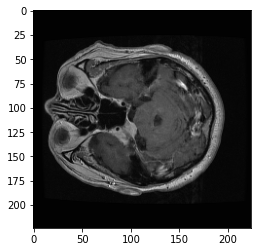

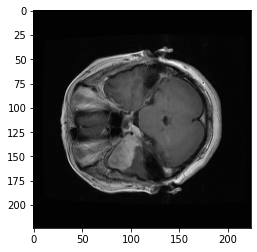

Instructions for updating:
Please use Model.fit, which supports generators.


722

In [11]:
  def upd(dk,data):
    if dk==0:
        dk=data
    else:
        for ky in data.keys():
            dk[ky].extend(data[ky])
    return dk
  index=5
  epoch=50
  pre_acc=0
  best=0
  fold='fold_'+str(index)
  trn,tst=get_trn_tst(df,index)
  history_last[fold]=0



  plt.imshow(trn[0][0])
  plt.show()
  plt.imshow(tst[0][0])
  plt.show()



  trn_x,trn_y=unison_shuffled_copies(trn[0],trn[1])
  tst_x,tst_y=unison_shuffled_copies(tst[0],tst[1])



  model=load_model()


  
  #compiling the model
  model.compile(optimizer=Adam(5e-5,decay=1e-6), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])
  train_data = DataGenerator(trn_x,pd.get_dummies(trn_y), batch_size=4, augment=True)
  ln=len(trn_y)
  # del([trn_x,trn_y,trn,tst])
  # gc.collect()
  #fitting the model
  #timing
  start=time.time()
  hist=model.fit_generator(train_data,epochs=50,steps_per_epoch=ln//4,verbose=0)
  history_last[fold]=upd(history_last[fold],hist.history)

  end=time.time()
  times_last[fold]=end-start

  #getting the prediction 
  pre=model.predict(tst_x)
  



  #select the maximum position
  pre=np.argmax(pre,1)
  predictions_last[fold]=pre

  
  
  
  #getting the accuracy
  new_acc=accuracy_score(pre,tst_y)

  


  #storing the predictions
  final_accuracy_last[fold]=new_acc








  #storing the answers
  answers_last[fold]=tst_y
    
    
    
    
  #freeing memory
  del([tst_x,tst_y])
  gc.collect()

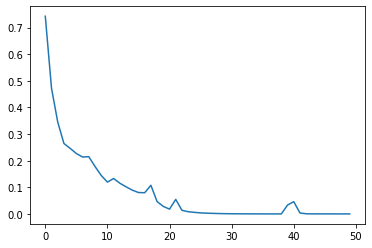

In [12]:
plt.plot(history_last[fold]['loss'])

In [13]:
new_acc

0.9409020217729394

In [14]:
index=str(index)
type='final_7516_5_1'
model1='final'
path='/content/gdrive/My Drive/'
np.save(path+"/best_accuracy_all_fold_"+index+"_"+model1+"_"+type+".npy",best_accuracy_last)
np.save(path+'/final_accuracy_all_fold'+index+"_"+model1+"_"+type+".npy",final_accuracy_last)
np.save(path+'/history_all_fold_'+index+"_"+model1+"_"+type+".npy",history_last)
np.save(path+'/answers_all_fold_'+index+"_"+model1+"_"+type+".npy",answers_last)
np.save(path+'/predictions_all_fold_'+index+"_"+model1+"_"+type+".npy",predictions_last)
np.save(path+'/predictions_all_best_fold_'+index+"_"+model1+"_"+type+".npy",predictions_last_best)
np.save(path+'/times_all_fold_'+index+"_"+model1+"_"+type+".npy",times_last)
model.save_weights(path+'wts2'+index+"_"+model1+'.hdf5')